In [1]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np
import numpy.linalg as la
from argparse import Namespace
import matplotlib.pyplot as plt
import time

In [39]:
K = 50
parameters = dict(K=K, ri=np.zeros(3), vi=np.zeros(3), ai=np.zeros(3),
                  rf=np.array([.4,.0,0]), vf=np.zeros(3), af=np.zeros(3),
                  wp=np.array([.2,.1,0]), wp_idx=int(K/3),
                  gravity=np.array([0.,0.,-9.81]),
                  v_max=.8, a_min=5., a_max=12.0, 
                  theta_max=np.radians(45.0),
                  j_max=40, max_iter=30,
                  weight_ri=1e3, weight_rf=1e4, weight_wp=1e4,
                  weight_obs=1e2, weight_trust=1e-2, n_obs=1)

""" Initialize parameters """
P = Namespace(**parameters)

ri = cp.Parameter(3)
vi = cp.Parameter(3)
ai = cp.Parameter(3)
rf = cp.Parameter(3)
vf = cp.Parameter(3)
af = cp.Parameter(3)
wp = cp.Parameter(3)

w_rf = cp.Parameter()
w_wp = cp.Parameter()
w_trust = cp.Parameter()
# w_obs = cp.Parameter()
# w_ri = cp.Parameter()

ri.value = P.ri
vi.value = P.vi
ai.value = P.ai
rf.value = P.rf
vf.value = P.vf
af.value = P.af
wp.value = P.wp

w_rf.value = P.weight_rf
w_wp.value = P.weight_wp
w_trust.value = P.weight_trust
# w_obs.value = P.weight_obs
# w_ri.value = P.weight_ri

""" Initialize variables """
r = cp.Variable((P.K, 3))
v = cp.Variable((P.K, 3))
a = cp.Variable((P.K, 3))
dtau = cp.Variable()

r0 = cp.Parameter((P.K, 3))
v0 = cp.Parameter((P.K, 3))
a0 = cp.Parameter((P.K, 3))
tau = cp.Parameter()

s = cp.Variable(P.K, nonneg=True)
eta = cp.Variable((P.K, P.n_obs), nonneg=True)
delta = cp.Variable((P.K, 2), nonneg=True)
trust = cp.Variable(nonneg=True)

rf_relax = cp.Variable(3)
ri_relax = cp.Variable(3)
wp_relax = cp.Variable(3)

s_ri = cp.Variable()
s_rf = cp.Variable()
s_wp = cp.Variable()

sigma = cp.Variable(nonneg=True)
# helper variables to maintain disciplined parametric programming
raccel = cp.Variable((P.K-1, 3))
Dt_raccel = cp.Variable((P.K-1, 3))

f = 0
g = dict() 

""" Define cost """
f += cp.norm(s)
f += tau + dtau
# f += w_ri*s_ri
f += w_rf*s_rf
f += w_wp*s_wp
f += w_trust*trust

g["relax_rf"] = s_rf >= cp.norm(rf_relax)**2
g["relax_wp"] = s_wp >= cp.norm(wp_relax)**2
# g["relax_ri"] = s_ri >= cp.norm(ri_relax)

""" Trust Region """
g["trust_dtau"] = cp.abs(dtau) <= trust
# g["trust_pos"] = cp.abs(r[:,:2] - r0[:,:2]) <= delta
# g["trust_obs"] = cp.sum(delta) <= trust

""" Boundary conditions """
g["pos_initial"] = r[0] == ri #+ ri_relax
g["pos_final"] = r[-1] == rf + rf_relax
g["vel_initial"] = v[0] == vi
g["vel_final"] = v[-1] == vf
g["waypoint"] = r[P.wp_idx] == wp + wp_relax
g["accel_initial"] = a[0,:2] == ai[:2]
g["accel_final"] = a[-1,:2] == af[:2]

""" Dynamics """
grav = np.tile(P.gravity, (P.K-1, 1)) 

g["helper_raccel"] = raccel == 1/2*(1/3*(2*a[:-1] + a[1:]) + grav)*tau
g["helper_Dt_raccel"] = Dt_raccel == (1/3*(2*a0[:-1] + a0[1:]) + grav)*dtau

g["dynamics_pos"] = \
r[1:] == r[:-1] + (v[:-1] + raccel)*tau + v0[:-1]*dtau + Dt_raccel*tau
g["dynamics_vel"] = \
v[1:] == v[:-1] + 1/2*(a[:-1] + a[1:] + grav)*tau \
       + 1/2*(a0[:-1] + a0[1:] + grav)*dtau# + v_virtual

""" State constraints """
g["height_max"] = r[:,2] <= 0
g["height_min"] = -r[:,2] >= 0
g["vertical_vel"] = cp.abs(v[:,2]) <= 0
g["vel_max"] = cp.norm(v, axis=1) <= P.v_max
g["horizontal_jerk_max"] = cp.norm(a[:-1] - a[1:], 2, axis=1) <= P.j_max*(tau + dtau)
#g += [P.cpos_A@@r <= np.tile(P.cpos_b, (K,1))]

g["lossless"] = cp.norm(a, axis=1) <= s
g["bank_angle"] = np.cos(P.theta_max)*s <= a[:,2]
g["thrust_min"] = P.a_min <= s 
g["thrust_max"] = s <= P.a_max

def update(r,v,a,t):
    r0.value = r
    v0.value = v
    a0.value = a
    tau.value = t
    
prob = cp.Problem(cp.Minimize(f), list(g.values()))
zeros = np.zeros((P.K,3))  
update(zeros, zeros, zeros, 0.5)
log_time = [time.time()]
for _ in range(P.max_iter):
    log_time.append(time.time())
    out = prob.solve(solver="ECOS", warm_start=True)
    if out == np.inf:
        print("FAILED")
        break
    print(f"T={P.K*tau.value:.2f}s "
          f"trust={trust.value:.5f} "\
          f"rf_relax={la.norm(rf_relax.value):.5f} "
          f"wp_relax={la.norm(wp_relax.value):.5f} ")
    if np.isclose(trust.value,0):
        break
#     P.rf[1] += _/1000
    
    update(r.value, v.value, a.value, tau.value + dtau.value)
    
time_avg = np.diff(log_time).mean()*1000
time_max = np.diff(log_time).max()*1000
time_fps = 1/np.diff(log_time).mean()
print(f"  {time_fps:.1f}fps ({time_avg:.2f}ms, max: {time_max:.2f}ms)")


T=25.00s trust=0.13968 rf_relax=4.87919 wp_relax=1.59320 
T=18.02s trust=0.15813 rf_relax=0.00000 wp_relax=0.00000 
T=10.11s trust=0.09530 rf_relax=0.00000 wp_relax=0.00000 
T=5.35s trust=0.05199 rf_relax=0.00000 wp_relax=0.00000 
T=2.75s trust=0.02711 rf_relax=0.00000 wp_relax=0.00000 
T=1.39s trust=0.00660 rf_relax=0.04886 wp_relax=0.04181 
T=1.06s trust=0.00269 rf_relax=0.06815 wp_relax=0.03952 
T=1.20s trust=0.00015 rf_relax=0.06814 wp_relax=0.04015 
T=1.19s trust=0.00000 rf_relax=0.06815 wp_relax=0.04013 
T=1.19s trust=0.00000 rf_relax=0.06815 wp_relax=0.04014 
T=1.19s trust=0.00000 rf_relax=0.06814 wp_relax=0.04015 
T=1.19s trust=0.00000 rf_relax=0.06812 wp_relax=0.04017 
T=1.19s trust=0.00000 rf_relax=0.06811 wp_relax=0.04018 
T=1.19s trust=0.00000 rf_relax=0.06810 wp_relax=0.04019 
T=1.19s trust=0.00000 rf_relax=0.06809 wp_relax=0.04020 
T=1.19s trust=0.00000 rf_relax=0.06808 wp_relax=0.04021 
T=1.19s trust=0.00000 rf_relax=0.06808 wp_relax=0.04022 
T=1.19s trust=0.00000 rf_rel

In [40]:
la.norm(a.value, axis=1)

array([4.91224935, 4.98968872, 5.26937663, 5.67179452, 6.21890139,
       6.83474777, 6.946972  , 6.84030968, 6.22379459, 5.67581863,
       5.27227114, 4.99121935, 4.91226497, 4.91054499, 4.99999993,
       5.00000001, 5.11130658, 5.15701092, 5.14506964, 5.10765004,
       5.10029301, 5.06727262, 5.0645898 , 5.03609435, 5.03815274,
       5.01428653, 5.02112813, 5.00197252, 5.01361198, 5.00000055,
       5.01564727, 5.00605307, 5.02722221, 5.02242122, 5.04827096,
       5.04823835, 5.07867596, 5.08335879, 5.11827052, 5.12759175,
       5.1668434 , 5.18070379, 5.22414412, 5.24242498, 5.28988895,
       5.31245498, 5.36376693, 5.25578835, 5.00392475, 4.89774695])

In [41]:
s.value

array([5.00000001, 5.00000001, 5.26937664, 5.67179453, 6.2189014 ,
       6.83474777, 6.946972  , 6.84030968, 6.2237946 , 5.67581864,
       5.27227115, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000003, 5.11130659, 5.15701093, 5.14506966, 5.10765006,
       5.10029303, 5.06727263, 5.06458981, 5.03609437, 5.03815275,
       5.01428654, 5.02112814, 5.00197253, 5.013612  , 5.00000056,
       5.01564728, 5.00605308, 5.02722222, 5.02242123, 5.04827097,
       5.04823836, 5.07867597, 5.0833588 , 5.11827053, 5.12759176,
       5.16684341, 5.1807038 , 5.22414413, 5.24242499, 5.28988896,
       5.31245499, 5.36376694, 5.25578836, 5.00392476, 5.00000001])

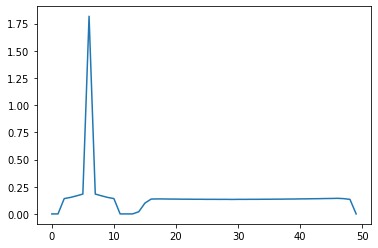

In [42]:
plt.plot(g["lossless"].dual_value)

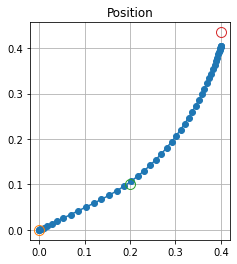

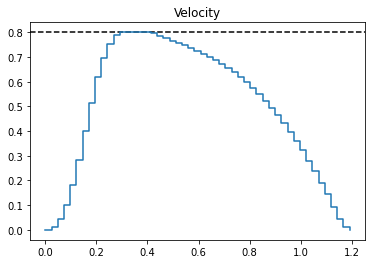

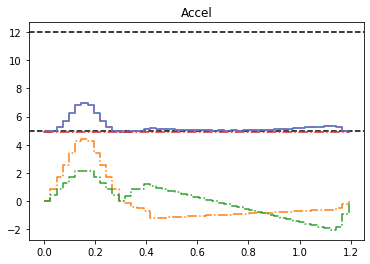

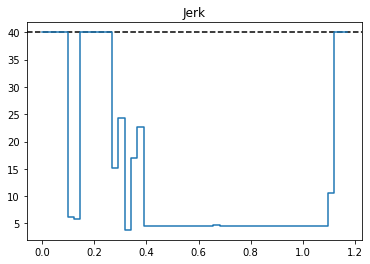

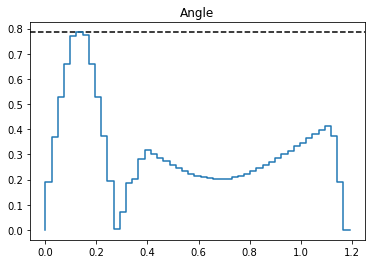

In [43]:
t = np.linspace(0,P.K*tau.value,P.K) 
plt.figure()
plt.title("Position")
plt.plot(*r.value[:,:2].T, 'o-')
plt.plot(*ri.value[:2], 'o', fillstyle='none', ms=10)
plt.plot(*wp.value[:2], 'o', fillstyle='none', ms=10)
plt.plot(*rf.value[:2], 'o', fillstyle='none', ms=10)
plt.gca().set_aspect('equal')
plt.grid()
#plt.plot(r.value[:,2], 'o-')
plt.figure()
plt.title("Velocity")
plt.gca().axhline(y=P.v_max, color='k', ls='--')
plt.step(t, la.norm(v.value, axis=1), where="post")
# plt.plot(t, v.value, '-.')
plt.figure()
plt.title("Accel")
plt.gca().axhline(y=P.a_min, color='k', ls='--')
plt.gca().axhline(y=P.a_max, color='k', ls='--')
plt.step(t, la.norm(a.value, axis=1), where="post")
plt.step(t, a.value, '-.', where="post")
plt.step(t, s.value, '-.', where="post")
plt.figure()
plt.title("Jerk")
plt.gca().axhline(y=P.j_max, color='k', ls='--')
plt.step(t[:-1], la.norm(np.diff(a.value, axis=0), axis=1)/tau.value)
#plt.plot(t, a.value, '-.')
plt.figure()
plt.title("Angle")
plt.gca().axhline(y=P.theta_max, color='k', ls='--')
bank_angle = np.arccos(a.value.dot(-P.gravity)/(la.norm(a.value,axis=1)*la.norm(P.gravity)))
plt.step(t, bank_angle)
plt.show()

In [7]:
g["vel_initial"].dual_value

array([132.45715016,  67.80700267,  26.41207431])

In [8]:
g["vel_final"].dual_value

array([ 0.30480827, -1.98241883, 10.38670988])

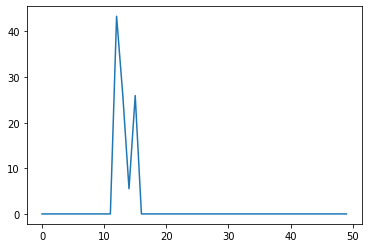

In [9]:
plt.plot(g["vel_max"].dual_value)

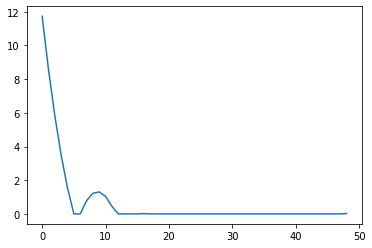

In [10]:
plt.plot(g["horizontal_jerk_max"].dual_value)

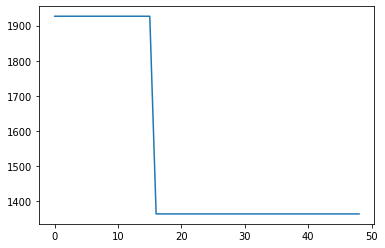

In [11]:
plt.plot(la.norm(g["dynamics_pos"].dual_value,axis=1))

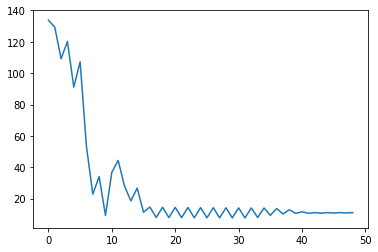

In [12]:
plt.plot(la.norm(g["dynamics_vel"].dual_value,axis=1))

In [13]:
z = cp.Variable()
zz = cp.Variable()

cp.Problem(cp.Minimize(z+zz), [z*zz==0]).solve()

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
var755 @ var756 == 0.0 , because the following subexpressions are not:
|--  var755 @ var756